In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import re
from bs4 import BeautifulSoup
import unicodedata

In [2]:
df_train=pd.read_csv('twitter_training.csv',header=None)
df_val=pd.read_csv('twitter_validation.csv',header=None)
# concatenate data
df = pd.concat([df_train, df_val], ignore_index=False)

In [3]:
df

0                    1           2  \
0    2401          Borderlands    Positive   
1    2401          Borderlands    Positive   
2    2401          Borderlands    Positive   
3    2401          Borderlands    Positive   
4    2401          Borderlands    Positive   
..    ...                  ...         ...   
995  4891  GrandTheftAuto(GTA)  Irrelevant   
996  4359                CS-GO  Irrelevant   
997  2652          Borderlands    Positive   
998  8069            Microsoft    Positive   
999  6960      johnson&johnson     Neutral   

                                                     3  
0    im getting on borderlands and i will murder yo...  
1    I am coming to the borders and I will kill you...  
2    im getting on borderlands and i will kill you ...  
3    im coming on borderlands and i will murder you...  
4    im getting on borderlands 2 and i will murder ...  
..                                                 ...  
995  ⭐️ Toronto is the arts and culture capital of ...  
996  tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...  
997  Today sucked so it’s time to drink wine n play...  
998  Bought a fraction of Microsoft today. Small wins.  
999  Johnson & Johnson to stop selling talc baby po...  

[75682 rows x 4 columns]

In [4]:
# Renaming columns
df.rename(columns={
    0: "id",
    1: "topic",
    2: "sentiment",
    3: "tweet"
}, inplace=True)
df

id                topic   sentiment  \
0    2401          Borderlands    Positive   
1    2401          Borderlands    Positive   
2    2401          Borderlands    Positive   
3    2401          Borderlands    Positive   
4    2401          Borderlands    Positive   
..    ...                  ...         ...   
995  4891  GrandTheftAuto(GTA)  Irrelevant   
996  4359                CS-GO  Irrelevant   
997  2652          Borderlands    Positive   
998  8069            Microsoft    Positive   
999  6960      johnson&johnson     Neutral   

                                                 tweet  
0    im getting on borderlands and i will murder yo...  
1    I am coming to the borders and I will kill you...  
2    im getting on borderlands and i will kill you ...  
3    im coming on borderlands and i will murder you...  
4    im getting on borderlands 2 and i will murder ...  
..                                                 ...  
995  ⭐️ Toronto is the arts and culture capital of ...  
996  tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...  
997  Today sucked so it’s time to drink wine n play...  
998  Bought a fraction of Microsoft today. Small wins.  
999  Johnson & Johnson to stop selling talc baby po...  

[75682 rows x 4 columns]

In [5]:
df['sentiment'].value_counts()

sentiment
Negative      22808
Positive      21109
Neutral       18603
Irrelevant    13162
Name: count, dtype: int64

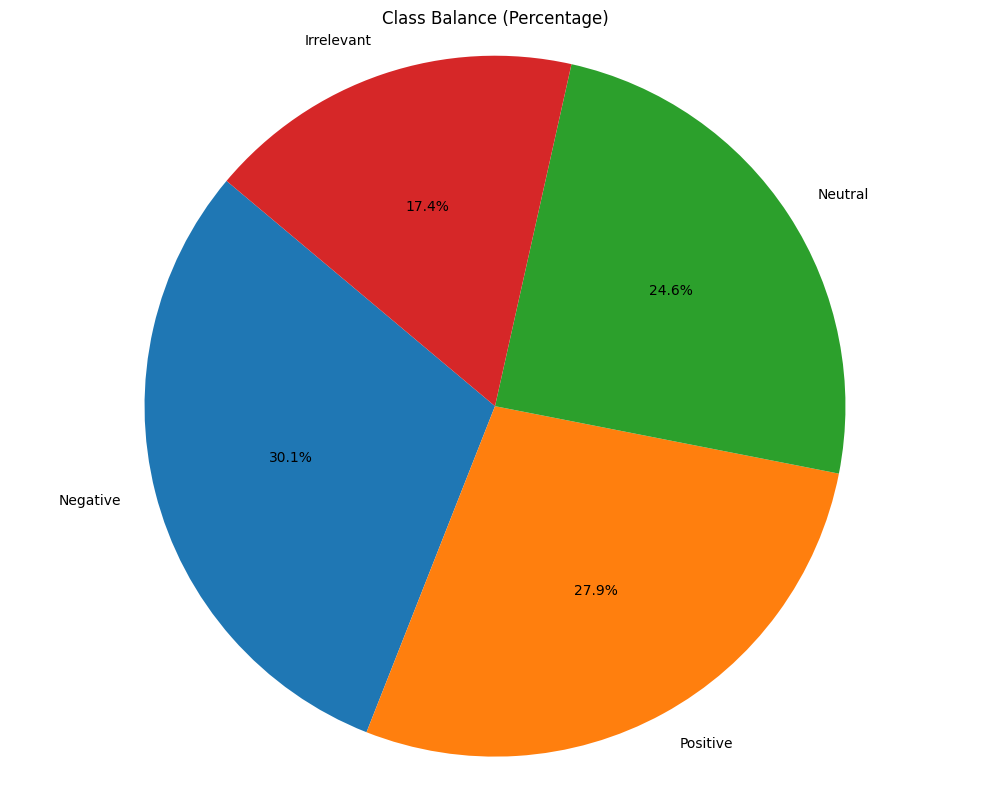

In [6]:
# Calculate class counts
class_counts = df['sentiment'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [7]:
print(df.isnull().sum())

id             0
topic          0
sentiment      0
tweet        686
dtype: int64


In [8]:
df.dropna(inplace=True)
df.isnull().sum()   

id           0
topic        0
sentiment    0
tweet        0
dtype: int64

In [9]:
df.duplicated().sum()

2857

In [10]:
# remove duplicate values 
remove_duplicates = df.drop_duplicates()
df = remove_duplicates
# check duplicate values
df.duplicated().sum()

0

# Remove Non-String

In [11]:
def filter_non_string(df, column):
    """
    Filter out rows with non-string values in the specified column.
    Convert non-string values to strings.
    """
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

In [12]:
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def clean(text):
    if pd.isnull(text):
        return ""
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs or hyperlinks from the text.
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Exclude numerical digits from the text."""
    text = re.sub(r'\d+', '', text)
    
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text) 

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    doc = nlp(text)
    
    # Lemmatize tokens, remove stop words, punctuation, and non-alphabetic tokens
    filtered_tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words 
                       and not token.is_punct and token.is_alpha]

    return " ".join(filtered_tokens) 

In [13]:
def remove_emojis(text):
    """Remove emojis from the text."""
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [14]:
def preprocess_text(df):
    df = filter_non_string(df, 'tweet')
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(remove_emojis)
    return df
df_processed = preprocess_text(df)

In [15]:
df_processed

id                topic   sentiment  \
0    2401          Borderlands    Positive   
1    2401          Borderlands    Positive   
2    2401          Borderlands    Positive   
3    2401          Borderlands    Positive   
4    2401          Borderlands    Positive   
..    ...                  ...         ...   
988  7516      LeagueOfLegends     Neutral   
989  5708            HomeDepot    Positive   
991  2165           CallOfDuty     Neutral   
995  4891  GrandTheftAuto(GTA)  Irrelevant   
996  4359                CS-GO  Irrelevant   

                                                 tweet  
0                                get borderland murder  
1                                     come border kill  
2                                  get borderland kill  
3                               come borderland murder  
4                                get borderland murder  
..                                                 ...  
988  suikoden alex kidd miracle world persona soul ...  
989  thank match fund home depot rw payment generou...  
991  late night stream boy come watch warzone run s...  
995  toronto art culture capital canada wonder want...  
996  actually good move tot bring viewer one people...  

[72139 rows x 4 columns]

In [16]:
print(df_processed.isnull().sum())

id           0
topic        0
sentiment    0
tweet        0
dtype: int64


In [17]:
print(df_processed.duplicated().sum())

8131


In [18]:
# remove duplicate values 
remove_duplicates = df_processed.drop_duplicates()
df_processed = remove_duplicates
# check duplicate values
df_processed.duplicated().sum()

0

In [19]:
df_processed

id          topic   sentiment  \
0     2401    Borderlands    Positive   
1     2401    Borderlands    Positive   
2     2401    Borderlands    Positive   
3     2401    Borderlands    Positive   
6     2402    Borderlands    Positive   
..     ...            ...         ...   
975  12949  Xbox(Xseries)  Irrelevant   
980   5495    Hearthstone    Positive   
984   1373    Battlefield    Negative   
989   5708      HomeDepot    Positive   
991   2165     CallOfDuty     Neutral   

                                                 tweet  
0                                get borderland murder  
1                                     come border kill  
2                                  get borderland kill  
3                               come borderland murder  
6    spend hour make something fun not know huge bo...  
..                                                 ...  
975  microsoft apparently firstparty xbox studio no...  
980  team great mediaannouncement day guy always ma...  
984  notice streamer watch play game battlefield v ...  
989  thank match fund home depot rw payment generou...  
991  late night stream boy come watch warzone run s...  

[64008 rows x 4 columns]

In [20]:
df_processed['tweet'].nunique()
df_processed['tweet'].value_counts()

tweet
                                                                                                                                                                                                                 1629
first time eu commission take step                                                                                                                                                                                172
time despite fact currently million people live poverty line access health service access health care access health care                                                                                          172
wow                                                                                                                                                                                                                32
love                                                                                                                                      

In [21]:
# Filter out non-unique tweets
df_unique_tweets = df_processed[df_processed['tweet'].map(df_processed['tweet'].value_counts()) == 1]

# Filter out unique tweets
df_duplicate_tweets = df_processed[df_processed.duplicated(subset=['tweet'], keep=False)]

# Concatenate the two dataframes
df_processed = pd.concat([df_unique_tweets, df_duplicate_tweets.drop_duplicates(subset=['tweet'], keep='first')])
df_processed

id                 topic sentiment  \
0       2401           Borderlands  Positive   
1       2401           Borderlands  Positive   
2       2401           Borderlands  Positive   
3       2401           Borderlands  Positive   
6       2402           Borderlands  Positive   
...      ...                   ...       ...   
70487  10875  TomClancysGhostRecon  Positive   
71724  11087  TomClancysGhostRecon   Neutral   
72936   8894                Nvidia   Neutral   
73019   8907                Nvidia  Negative   
74514   9173                Nvidia   Neutral   

                                                   tweet  
0                                  get borderland murder  
1                                       come border kill  
2                                    get borderland kill  
3                                 come borderland murder  
6      spend hour make something fun not know huge bo...  
...                                                  ...  
70487                                         ghostrecon  
71724         ghost recon breakpoint storeplaystationcom  
72936                                         watch part  
73019                                             nvidia  
74514                                               next  

[61066 rows x 4 columns]

## Tokenization with RegexpTokenizer

In [22]:
tokenizer = RegexpTokenizer(r"\b[a-zA-Z']+\b") # \b : Marque le début d'un mot (boundary)./ [a-zA-Z']+ : Capture une séquence de caractères alphabétiques (majuscules et minuscules) et d'apostrophes. / \b : Marque la fin d'un mot (boundary).
# Initialize an empty list to store all tokens
corpus_tokens = []

# Tokenize each tweet and add tokens to the corpus list
for tweet in df_processed['tweet']:
    tokens = tokenizer.tokenize(tweet)
    # Filter out tokens with length less than or equal to 2
    filtered_tokens = [token for token in tokens if len(token) > 2]
    corpus_tokens.extend(tokens)
corpus_tokens

['get',
 'borderland',
 'murder',
 'come',
 'border',
 'kill',
 'get',
 'borderland',
 'kill',
 'come',
 'borderland',
 'murder',
 'spend',
 'hour',
 'make',
 'something',
 'fun',
 'not',
 'know',
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorite',
 'character',
 'decide',
 'make',
 'wallpaper',
 'pc',
 'original',
 'image',
 'versus',
 'creation',
 'make',
 'enjoy',
 'pictwittercommlsiwfjg',
 'spend',
 'couple',
 'hour',
 'something',
 'fun',
 'not',
 'know',
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorite',
 'character',
 'decide',
 'make',
 'wallpaper',
 'pc',
 'here',
 'original',
 'picture',
 'compare',
 'creation',
 'make',
 'fun',
 'pictwittercom',
 'mlsiwfjg',
 'spend',
 'hour',
 'something',
 'fun',
 'not',
 'know',
 'huge',
 'borderland',
 'fan',
 'maya',
 'one',
 'favorite',
 'character',
 'spend',
 'hour',
 'make',
 'something',
 'fun',
 'not',
 'know',
 'huge',
 'rhandlerr',
 'fan',
 'maya',
 'one',
 'favorite',
 'character',
 'decide',
 'make',
 'wal

# Bag of words
* **Bag-of-Words (BoW):**  A simple encoding method that represents a text document as a vector of word counts.  It ignores word order and focuses only on the frequency of words.


In [23]:
tweet = ' '.join(df_processed['tweet'])
data = sent_tokenize(tweet)
word2count = {}
for d in data:
    words = word_tokenize(d)
    for word in words:
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
print(word2count)

{'get': 7442, 'borderland': 1408, 'murder': 92, 'come': 1946, 'border': 64, 'kill': 986, 'spend': 456, 'hour': 813, 'make': 3660, 'something': 899, 'fun': 1419, 'not': 8459, 'know': 2020, 'huge': 393, 'fan': 575, 'maya': 18, 'one': 3477, 'favorite': 584, 'character': 532, 'decide': 269, 'wallpaper': 11, 'pc': 761, 'original': 227, 'image': 99, 'versus': 17, 'creation': 6, 'enjoy': 755, 'pictwittercommlsiwfjg': 2, 'couple': 156, 'here': 174, 'picture': 168, 'compare': 115, 'pictwittercom': 871, 'mlsiwfjg': 1, 'rhandlerr': 1359, 'rockhard': 4, 'la': 75, 'varlope': 4, 'rare': 37, 'powerful': 165, 'handsome': 67, 'jackpot': 7, 'xbox': 1987, 'dlvritrmtrgf': 3, 'dlvrit': 64, 'rmtrgf': 3, 'dfrit': 7, 'vita': 12, 'live': 1116, 'rock': 115, 'hard': 597, 'music': 360, 'borderlands': 6, 'sega': 26, 'dlvr': 66, 'e': 394, 'ihard': 1, 'like': 4763, 'london': 21, 'de': 107, 'first': 1490, 'session': 85, 'long': 891, 'time': 2880, 'actually': 1047, 'really': 3040, 'satisfy': 40, 'combat': 58, 'experie

#  TF-IDF
* **TF-IDF (Term Frequency-Inverse Document Frequency):**  A more sophisticated encoding method that weights words based on their frequency within a document (TF) and their inverse document frequency (IDF).  IDF gives more weight to words that are rare across the entire corpus, making them more informative.

In [24]:
tfidf = TfidfVectorizer()
corpus = df_processed['tweet']

result = tfidf.fit_transform(corpus)
# get idf values
print('\nidf values:')
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    print(ele1, ':', ele2)
# get indexing
print('\nWord indexes:')
print(tfidf.vocabulary_)
# display tf-idf values
print('\ntf-idf value:')
print(result)
# in matrix form
print('\ntf-idf values in matrix form:')
print(result.toarray())


idf values:
aa : 10.22796743182639
aaa : 8.65243107106797
aaaaaaaaaaaa : 11.326579720494498
aaaaaaaaaaaaa : 10.921114612386333
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa : 11.326579720494498
aaaaaaaaaaage : 10.410288988620342
aaaaaaaaaage : 11.326579720494498
aaaaaasee : 11.326579720494498
aaaahhh : 10.22796743182639
aaarate : 10.921114612386333
aadii : 10.921114612386333
aadil : 10.633432539934553
aagainst : 11.326579720494498
aahqxwcz : 10.921114612386333
aajtak : 10.633432539934553
aall : 11.326579720494498
aamaavpjyc : 10.921114612386333
aarogya : 10.22796743182639
aaron : 8.975204463331021
aaroncarter : 10.633432539934553
aarongreenberg : 10.07381675199913
aaronrodger : 10.07381675199913
aat : 10.410288988620342
aatjkpem : 11.326579720494498
aatmanirbhar : 10.633432539934553
aatmanirvar : 11.326579720494498
aawea : 11.326579720494498
aaw

# WORD2VEC

Word2Vec was introduced in two papers between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by Gensim.

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

Okay, here are explanations of the concepts used in your notebook, formatted for Markdown:


#### 2. Data Encoding

* **Word Embeddings (Word2Vec):**  A technique for representing words as numerical vectors that capture semantic relationships between words.  Word2Vec models are trained on a corpus of text and learn to associate words that appear in similar contexts.

    * **CBOW (Continuous Bag of Words):**  Predicts a target word based on its surrounding context (neighboring words).
    * **Skip-Gram:**  Predicts the surrounding context words based on a given target word.

### Tokenizing the 'tweet' column to use it in Word2vec

In [25]:
# Initialiser les objets nécessaires
tokenizer = RegexpTokenizer(r"\b[a-zA-Z']+\b")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Tokeniser
    tokens = tokenizer.tokenize(text)
    # Supprimer les stop words et lemmatiser
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
    return tokens
    
df_processed['tweet'] = df_processed['tweet'].apply(preprocess_text)


In [26]:
df_processed.head(50)

id        topic sentiment  \
0   2401  Borderlands  Positive   
1   2401  Borderlands  Positive   
2   2401  Borderlands  Positive   
3   2401  Borderlands  Positive   
6   2402  Borderlands  Positive   
7   2402  Borderlands  Positive   
8   2402  Borderlands  Positive   
9   2402  Borderlands  Positive   
12  2403  Borderlands   Neutral   
13  2403  Borderlands   Neutral   
14  2403  Borderlands   Neutral   
15  2403  Borderlands   Neutral   
16  2403  Borderlands   Neutral   
17  2403  Borderlands   Neutral   
18  2404  Borderlands  Positive   
19  2404  Borderlands  Positive   
21  2404  Borderlands  Positive   
22  2404  Borderlands  Positive   
23  2404  Borderlands  Positive   
24  2405  Borderlands  Negative   
25  2405  Borderlands  Negative   
28  2405  Borderlands  Negative   
29  2405  Borderlands  Negative   
30  2406  Borderlands  Positive   
31  2406  Borderlands  Positive   
32  2406  Borderlands  Positive   
33  2406  Borderlands  Positive   
34  2406  Borderlands  Positive   
35  2406  Borderlands  Positive   
36  2407  Borderlands  Negative   
37  2407  Borderlands  Negative   
38  2407  Borderlands  Negative   
39  2407  Borderlands  Negative   
40  2407  Borderlands  Negative   
41  2407  Borderlands  Negative   
42  2408  Borderlands   Neutral   
44  2408  Borderlands   Neutral   
46  2408  Borderlands   Neutral   
48  2409  Borderlands   Neutral   
49  2409  Borderlands   Neutral   
50  2409  Borderlands   Neutral   
54  2410  Borderlands  Negative   
55  2410  Borderlands  Negative   
56  2410  Borderlands  Negative   
57  2410  Borderlands  Negative   
58  2410  Borderlands  Negative   
59  2410  Borderlands  Negative   
66  2412  Borderlands  Positive   
67  2412  Borderlands  Positive   
68  2412  Borderlands  Positive   

                                                tweet  
0                           [get, borderland, murder]  
1                                [come, border, kill]  
2                             [get, borderland, kill]  
3                          [come, borderland, murder]  
6   [spend, hour, make, something, fun, know, huge...  
7   [spend, couple, hour, something, fun, know, hu...  
8   [spend, hour, something, fun, know, huge, bord...  
9   [spend, hour, make, something, fun, know, huge...  
12  [rockhard, la, varlope, rare, powerful, handso...  
13  [rockhard, la, varlope, rare, powerful, handso...  
14  [rockhard, la, varlope, rare, powerful, handso...  
15  [rockhard, la, vita, rare, powerful, handsome,...  
16  [live, rock, hard, music, la, la, varlope, rar...  
17  [ihard, like, rare, london, de, handsome, bord...  
18  [first, borderland, session, long, time, actua...  
19  [first, borderland, session, long, time, actua...  
21  [first, borderland, session, long, time, actua...  
22  [first, real, borderland, session, nice, long,...  
23  [first, borderland, session, hot, row, actuall...  
24  [big, dissappoinment, life, come, year, ago, f...  
25       [big, disappointment, life, come, year, ago]  
28  [big, male, dissappoinment, life, came, hang, ...  
29  [big, dissappoinment, life, come, back, last, ...  
30  [finish, borderland, finally, yas, thank, hang...  
31  [finally, finally, find, borderland, yes, than...  
32  [thank, hang, everyone, fun, ill, try, get, ha...  
33  [finish, borderland, update, yas, thank, hang,...  
34  [finish, borderland, finally, yas, thank, ever...  
35  [finish, borderland, finally, yas, hey, hang, ...  
36  [man, gearbox, really, need, fix, dissapointin...  
37  [man, gearbox, really, need, fix, disappointin...  
38  [man, gearbox, really, need, fix, disssapointe...  
39  [man, bethesda, really, need, fix, dissapointi...  
40  [man, gearbox, really, need, fix, dissapointin...  
41  [gearbox, really, time, fix, drop, new, border...  
42                            [check, epic, streamer]  
44                          [watch, epic, striptease]  
46                       [check, big, epic, streamer]  
48  [blame, sight, tardiness, little

In [27]:
import multiprocessing
from gensim.models import  Word2Vec

cores = multiprocessing.cpu_count()

In [28]:
w2v_model = Word2Vec(min_count = 20, window= 2, vector_size= 300, sample= 6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

In [29]:
from time import time
sentences = df_processed['tweet'].tolist()
t = time()
w2v_model.build_vocab(sentences , progress_per = 10000)
print('Time to build vocab: {} mins'.format(round((time() -t) / 60, 2)))


Time to build vocab: 0.0 mins


In [30]:
w2v_model.corpus_count

61066

In [31]:
t = time()

w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.15 mins


In [32]:
w2v_model.init_sims(replace= True)

/tmp/ipykernel_69122/3273009569.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace= True)


In [33]:
w2v_model.wv.most_similar(positive=["gta"])

[('rockstargame', 0.4190214276313782),
 ('milk', 0.38259613513946533),
 ('rockstar', 0.3750106394290924),
 ('v', 0.36164921522140503),
 ('online', 0.3544483780860901),
 ('sudden', 0.3430916368961334),
 ('andreas', 0.3311150074005127),
 ('rockstarsupport', 0.3272879123687744),
 ('auto', 0.321418821811676),
 ('theft', 0.3141321539878845)]

In [34]:
w2v_model.wv.most_similar(positive=["wtf"])

[('valvesoftware', 0.3732343912124634),
 ('fix', 0.3512097895145416),
 ('mic', 0.32773250341415405),
 ('bennitegame', 0.32616904377937317),
 ('shit', 0.3252740204334259),
 ('lmfao', 0.31382817029953003),
 ('wraith', 0.31337976455688477),
 ('ffs', 0.31262701749801636),
 ('ubi', 0.31116822361946106),
 ('reload', 0.3087303638458252)]

In [35]:
w2v_model.wv.similarity("gta", "wtf")

0.012055118

# T-SNE Visualization

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

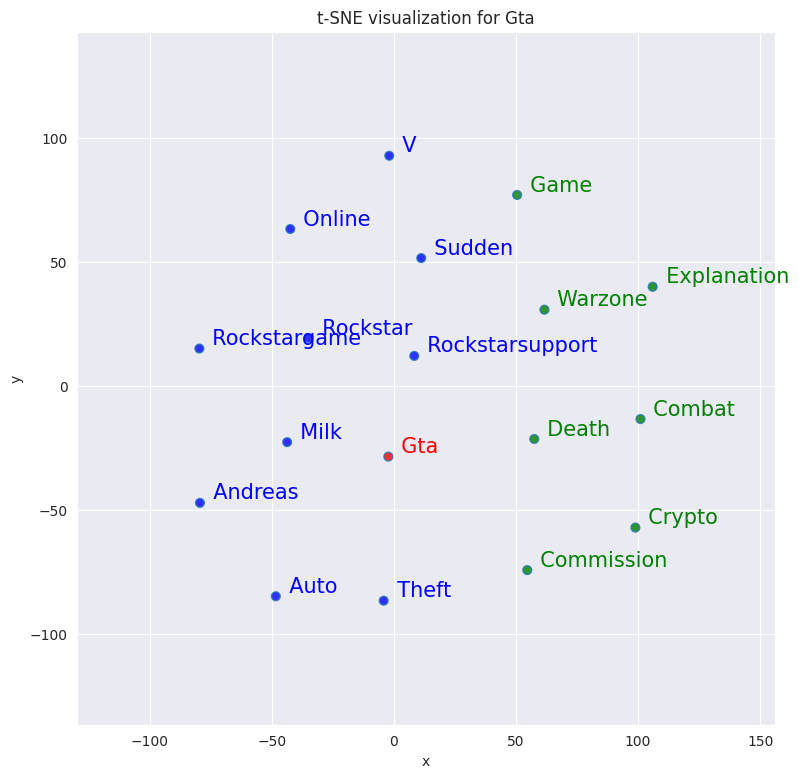

In [37]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list = ['red']

    # Add the vector of the query word
    arrays = np.append(arrays, model.wv[word].reshape(1, -1), axis=0)
    
    # Get list of most similar words
    close_words = model.wv.most_similar([word])
    
    # Add the vectors for the most similar words
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]].reshape(1, -1)
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Add the vectors for the words from list_names if they are in the vocabulary
    for wrd in list_names:
        if wrd in model.wv:
            wrd_vector = model.wv[wrd].reshape(1, -1)
            word_labels.append(wrd)
            color_list.append('green')
            arrays = np.append(arrays, wrd_vector, axis=0)
    
    # Reduces the dimensionality from 300 to 2 dimensions with PCA
    reduc = PCA(n_components=2).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min() - 50, Y[:, 0].max() + 50)
    plt.ylim(Y[:, 1].min() - 50, Y[:, 1].max() + 50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

# Example usage
tsnescatterplot(w2v_model, 'gta', ['crypto', 'warzone', 'sleeping', 'death', 'explanation', 'game', 'commission', 'combat'])


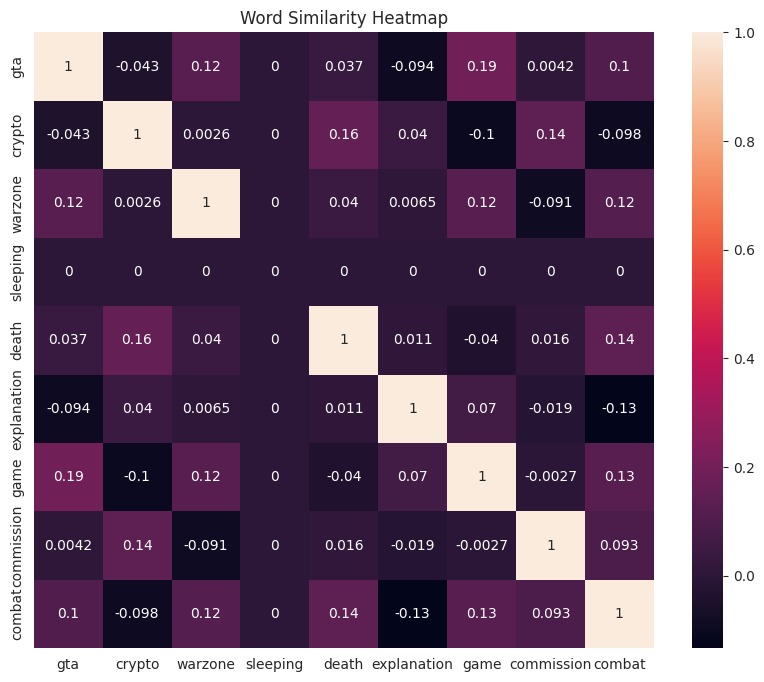

In [38]:
def similarity_heatmap(model, words):
    similarity_matrix = np.zeros((len(words), len(words)))
    
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if word1 in model.wv and word2 in model.wv:
                similarity_matrix[i][j] = model.wv.similarity(word1, word2)
            else:
                similarity_matrix[i][j] = 0
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, xticklabels=words, yticklabels=words, annot=True)
    plt.title('Word Similarity Heatmap')
    plt.show()

# Example usage
similarity_heatmap(w2v_model, ['gta','crypto', 'warzone', 'sleeping', 'death', 'explanation', 'game', 'commission', 'combat'])

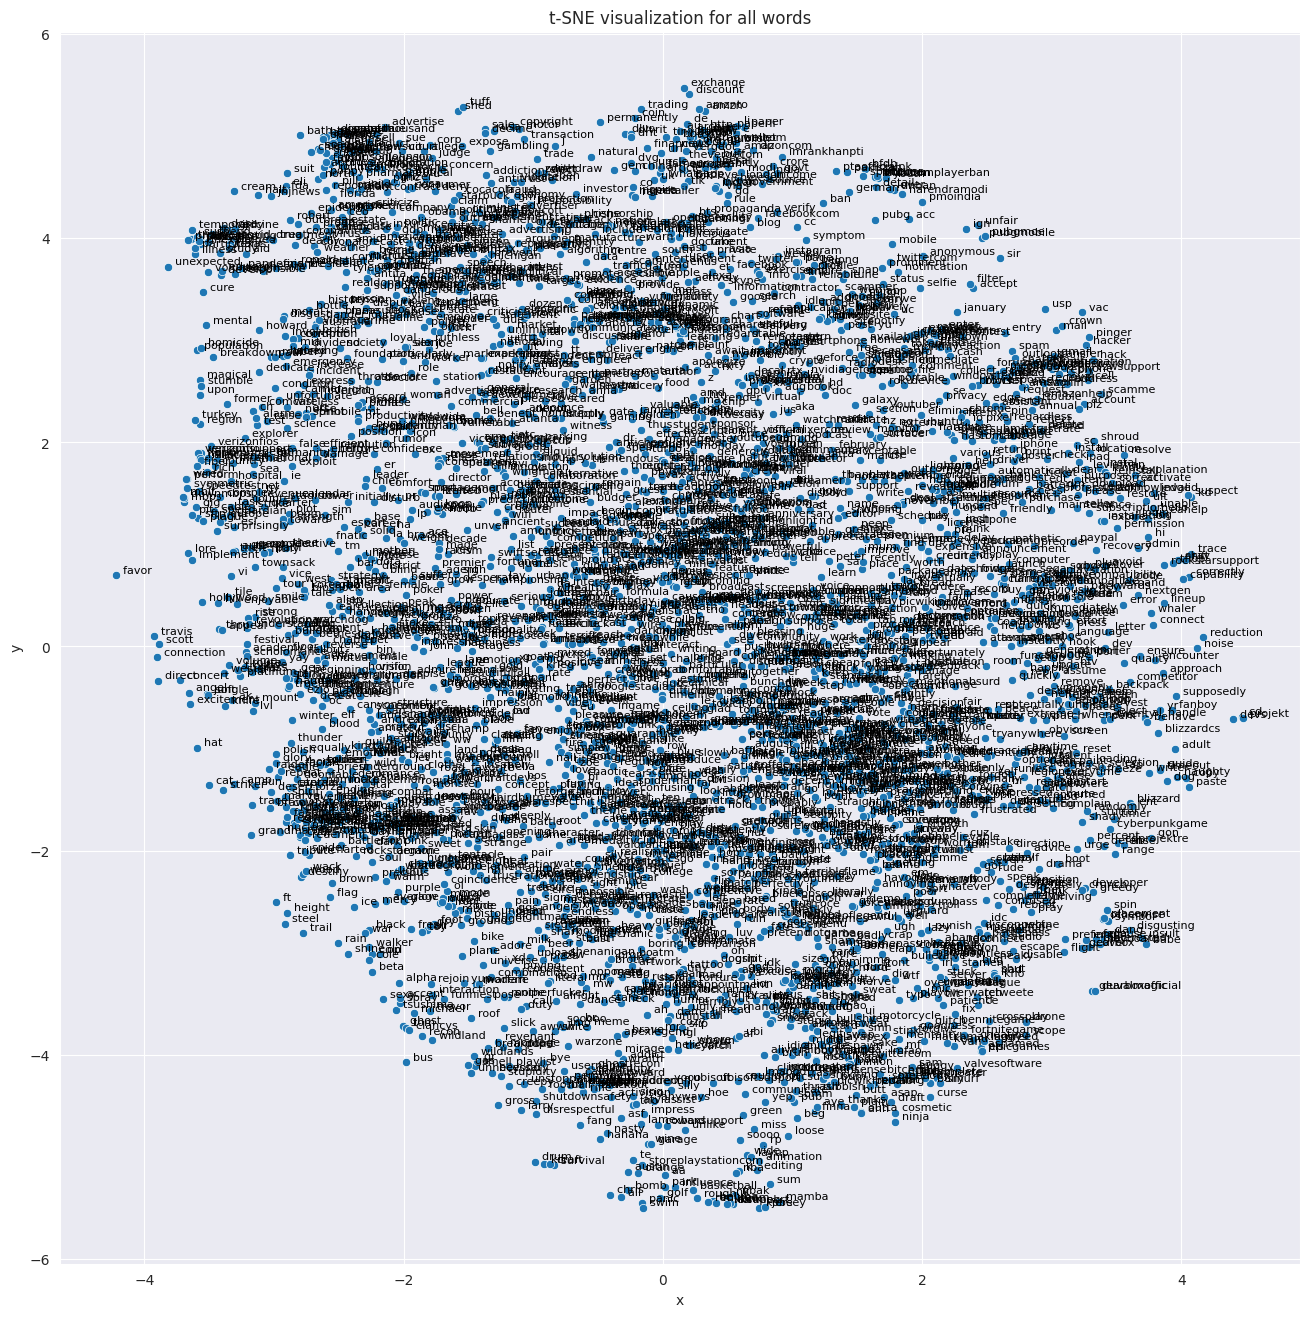

In [39]:
def tsne_all_words(model, exclude_word=None):
    # Get all words in the vocabulary
    words = list(model.wv.index_to_key)
    
    # Exclude the specified word
    if exclude_word:
        words.remove(exclude_word)
    
    # Get the vectors for all words
    vectors = np.array([model.wv[word] for word in words])
    
    # Reduce dimensions with PCA before applying t-SNE
    pca = PCA(n_components=50, random_state=0)
    pca_result = pca.fit_transform(vectors)
    
    tsne = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=300)
    tsne_result = tsne.fit_transform(pca_result)
    
    # Prepare DataFrame for visualization
    df_tsne = pd.DataFrame(tsne_result, columns=['x', 'y'])
    df_tsne['words'] = words
    
    # Plot
    plt.figure(figsize=(16, 16))
    p1 = sns.scatterplot(x='x', y='y', data=df_tsne, legend=False)
    
    for line in range(0, df_tsne.shape[0]):
        p1.text(df_tsne["x"][line], df_tsne['y'][line], '  ' + df_tsne["words"][line], 
                horizontalalignment='left', verticalalignment='bottom', size='medium', color='black', weight='normal').set_size(8)

    plt.title('t-SNE visualization for all words')
    plt.show()

# Create t-SNE plot for all words excluding "Italy"
tsne_all_words(w2v_model, exclude_word="italy")


In [40]:
def get_embedding(sentence, model):
    embeddings = [w2v_model.wv[word] for word in sentence if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

df_processed['embeddings'] = df_processed['tweet'].apply(lambda x: get_embedding(x, w2v_model))

In [41]:
df_processed

id                 topic sentiment  \
0       2401           Borderlands  Positive   
1       2401           Borderlands  Positive   
2       2401           Borderlands  Positive   
3       2401           Borderlands  Positive   
6       2402           Borderlands  Positive   
...      ...                   ...       ...   
70487  10875  TomClancysGhostRecon  Positive   
71724  11087  TomClancysGhostRecon   Neutral   
72936   8894                Nvidia   Neutral   
73019   8907                Nvidia  Negative   
74514   9173                Nvidia   Neutral   

                                                   tweet  \
0                              [get, borderland, murder]   
1                                   [come, border, kill]   
2                                [get, borderland, kill]   
3                             [come, borderland, murder]   
6      [spend, hour, make, something, fun, know, huge...   
...                                                  ...   
70487                                       [ghostrecon]   
71724    [ghost, recon, breakpoint, storeplaystationcom]   
72936                                      [watch, part]   
73019                                           [nvidia]   
74514                                             [next]   

                                              embeddings  
0      [-0.026281485, -0.004016316, -0.025742734, -0....  
1      [-0.04625143, 0.0034337435, 0.029118674, 0.047...  
2      [-0.06318036, -0.028009867, -0.043104943, 0.01...  
3      [-0.018873703, -0.0024633359, 0.020276299, -0....  
6      [-0.017027074, -0.03228297, -0.02150551, 0.000...  
...                                                  ...  
70487  [-0.000799516, 0.011216567, -0.05388595, 0.007...  
71724  [0.028107777, 0.02427904, -0.014775005, 0.0063...  
72936  [0.0021655746, -0.033883624, -0.040945467, 0.0...  
73019  [0.054595035, -0.07135243, -0.019076856, -0.09...  
74514  [-0.06826169, 0.012911817, 0.062116068, 0.0081...  

[61066 rows x 5 columns]

# Modeling

In [42]:
X = np.vstack(df_processed['embeddings'].values)
y = df_processed['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
# Step 3: Train Models
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)


# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

# Step 4: Evaluate Models
# Define evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    return accuracy, precision, recall, f1

/home/sasamg/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sasamg/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [46]:
# Evaluate SVM
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model(svm_model, X_test, y_test)

# Evaluate Logistic Regression
lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_model(lr_model, X_test, y_test)

# Evaluate AdaBoost
ada_accuracy, ada_precision, ada_recall, ada_f1 = evaluate_model(ada_model, X_test, y_test)


                 Model  Accuracy  Precision    Recall  F1 Score
0                  SVM  0.734976   0.734821  0.717853  0.723170
1  Logistic Regression  0.545276   0.522816  0.512920  0.510031
2             AdaBoost  0.486818   0.460135  0.453838  0.448339


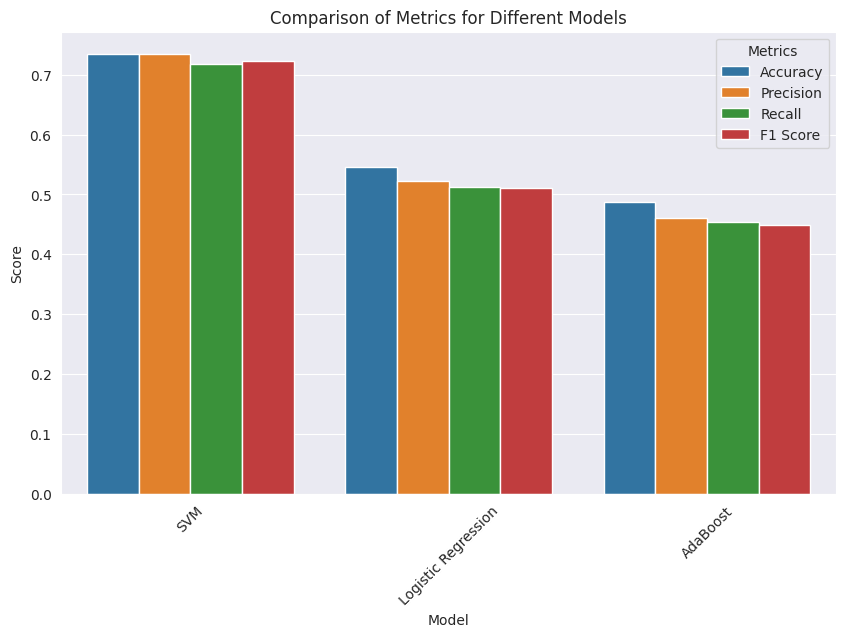

In [50]:
# Step 5: Compare Metrics and Visualize Results
models = ['SVM', 'Logistic Regression', 'AdaBoost']
accuracies = [svm_accuracy, lr_accuracy, ada_accuracy]
precisions = [svm_precision, lr_precision, ada_precision]
recalls = [svm_recall, lr_recall, ada_recall]
f1_scores = [svm_f1, lr_f1, ada_f1]

# Create a DataFrame to store metrics
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})
# Print metrics
print(metrics_df)

# Plot metrics comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(metrics_df, ['Model']))
plt.title('Comparison of Metrics for Different Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

Confusion Matrix and Classification Report for SVM


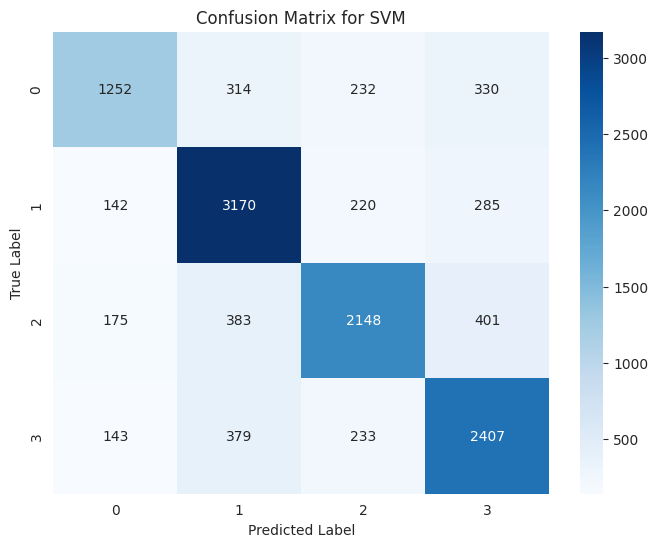

Classification Report for SVM
              precision    recall  f1-score   support

  Irrelevant       0.73      0.59      0.65      2128
    Negative       0.75      0.83      0.79      3817
     Neutral       0.76      0.69      0.72      3107
    Positive       0.70      0.76      0.73      3162

    accuracy                           0.73     12214
   macro avg       0.73      0.72      0.72     12214
weighted avg       0.74      0.73      0.73     12214

Confusion Matrix and Classification Report for Logistic Regression


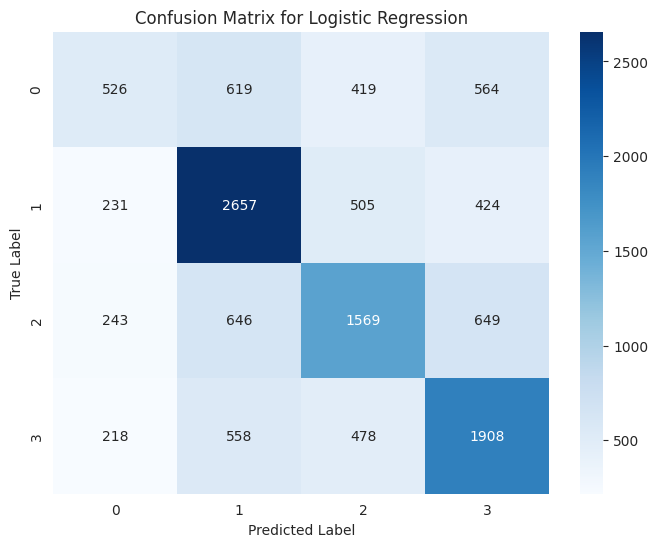

Classification Report for Logistic Regression
              precision    recall  f1-score   support

  Irrelevant       0.43      0.25      0.31      2128
    Negative       0.59      0.70      0.64      3817
     Neutral       0.53      0.50      0.52      3107
    Positive       0.54      0.60      0.57      3162

    accuracy                           0.55     12214
   macro avg       0.52      0.51      0.51     12214
weighted avg       0.53      0.55      0.53     12214

Confusion Matrix and Classification Report for AdaBoost


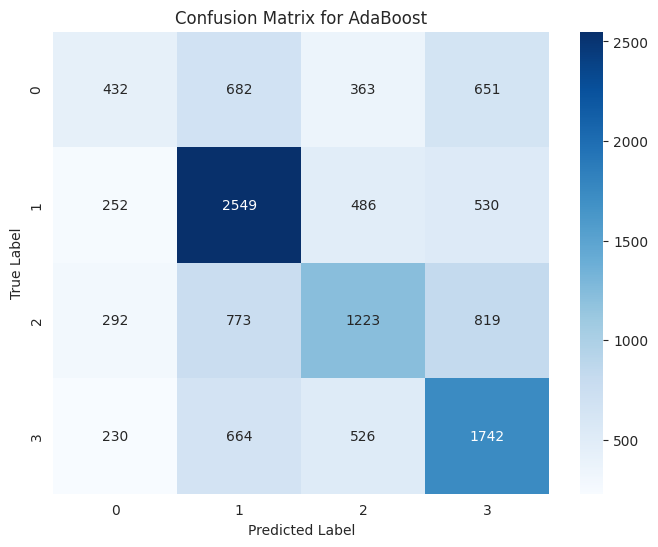

Classification Report for AdaBoost
              precision    recall  f1-score   support

  Irrelevant       0.36      0.20      0.26      2128
    Negative       0.55      0.67      0.60      3817
     Neutral       0.47      0.39      0.43      3107
    Positive       0.47      0.55      0.50      3162

    accuracy                           0.49     12214
   macro avg       0.46      0.45      0.45     12214
weighted avg       0.47      0.49      0.47     12214



In [52]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix and Classification Report for each model
for model_name, model in zip(models, [svm_model, lr_model, ada_model]):
    print(f"Confusion Matrix and Classification Report for {model_name}")
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Classification Report
    print(f"Classification Report for {model_name}")
    print(classification_report(y_test, y_pred))

### Conclusion and Analysis

The performance of the three models—Support Vector Machine (SVM), Logistic Regression, and AdaBoost—can be analyzed based on their accuracy, precision, recall, and F1 score. Here are the key takeaways from the results:

#### Performance Metrics Summary:
| Model                | Accuracy | Precision | Recall   | F1 Score |
|----------------------|----------|-----------|----------|----------|
| SVM                  | 0.734976 | 0.734821  | 0.717853 | 0.723170 |
| Logistic Regression  | 0.545276 | 0.522816  | 0.512920 | 0.510031 |
| AdaBoost             | 0.486818 | 0.460135  | 0.453838 | 0.448339 |

#### Support Vector Machine (SVM):
- **Accuracy**: 73.50%
- **Precision**: 73.48%
- **Recall**: 71.79%
- **F1 Score**: 72.32%

SVM outperforms the other two models significantly across all metrics. With an accuracy of 73.50%, it indicates that SVM is able to correctly classify a large majority of the instances. The precision and recall values are also high, suggesting that SVM not only captures a good portion of the true positives but also maintains a low false positive rate. The F1 score, which balances precision and recall, further confirms the robustness of the SVM model.

#### Logistic Regression:
- **Accuracy**: 54.53%
- **Precision**: 52.28%
- **Recall**: 51.29%
- **F1 Score**: 51.00%

Logistic Regression performs moderately, with an accuracy of 54.53%. While it's better than random guessing, its performance is considerably lower than that of SVM. The precision and recall values indicate that the model struggles to capture true positives effectively, and there is a higher rate of false positives compared to SVM. The F1 score reflects a balance between precision and recall but is still much lower than SVM, indicating that Logistic Regression is not as reliable for this dataset.

#### AdaBoost:
- **Accuracy**: 48.68%
- **Precision**: 46.01%
- **Recall**: 45.38%
- **F1 Score**: 44.83%

AdaBoost has the lowest performance among the three models. With an accuracy of 48.68%, it is barely better than random guessing. The precision, recall, and F1 score are all below 50%, suggesting that AdaBoost struggles significantly to classify the data correctly. This could be due to various factors such as the complexity of the data, insufficient tuning of hyperparameters, or the nature of the dataset itself.

### Conclusion:

**SVM is the best-performing model** among the three, based on all evaluation metrics. Its higher accuracy, precision, recall, and F1 score indicate that it is more effective at classifying the sentiment of tweets in the dataset compared to Logistic Regression and AdaBoost.

### Recommendations:
1. **Model Selection**: Based on the performance metrics, SVM should be the preferred model for this task.
2. **Hyperparameter Tuning**: Further tuning of SVM's hyperparameters could potentially improve its performance even more.
3. **Data Augmentation**: Increasing the amount of training data or applying techniques like oversampling/undersampling could help improve the performance of the other models.
4. **Feature Engineering**: Experimenting with different feature extraction methods (e.g., n-grams, more sophisticated embeddings) might improve the performance of Logistic Regression and AdaBoost.
5. **Ensemble Methods**: Combining models using ensemble techniques could potentially lead to better performance than any single model.

